In [1]:
#import julianday
import nbimporter
import datetime
import csv
import Gdata
from Gdata import Gdata
import Weather
from Weather import Weather, enmWeatherComponent
import WindowMng
from WindowMng import WindowMng, Window
import WallMng
from WallMng import WallMng
from Wall import Layer, Wall
import Schedule
from Schedule import Schedule
from ExsrfMng import ExsrfMng
import matplotlib.pyplot as plt
import Sunbrk
from Sunbrk import SunbrkMng, SunbrkType
import Space
from Space import SpaceMng
import SeasonalValue
from SeasonalValue import SeasonalValue
import SolarPosision
from SolarPosision import SolarPosision, defSolpos

Importing Jupyter notebook from Gdata.ipynb
Importing Jupyter notebook from Weather.ipynb
Importing Jupyter notebook from SolarPosision.ipynb
Importing Jupyter notebook from WindowMng.ipynb
Importing Jupyter notebook from WallMng.ipynb
Importing Jupyter notebook from Wall.ipynb
Importing Jupyter notebook from Schedule.ipynb
Importing Jupyter notebook from ACSet.ipynb
Importing Jupyter notebook from AnnualCal.ipynb
Importing Jupyter notebook from mdlLibrary.ipynb
Importing Jupyter notebook from Appl.ipynb
Importing Jupyter notebook from Light.ipynb
Importing Jupyter notebook from LocalVent.ipynb
Importing Jupyter notebook from Resi.ipynb
Importing Jupyter notebook from ExsrfMng.ipynb
Importing Jupyter notebook from Exsrf.ipynb
Importing Jupyter notebook from Sunbrk.ipynb
Importing Jupyter notebook from Space.ipynb
Importing Jupyter notebook from SeasonalValue.ipynb


# 室温・熱負荷計算のメイン関数

In [2]:
class heat_load_main():
    def __init__(self):
        pass
        
    #シミュレーション全体の設定条件の読み込み
    def Gdata_init(self):
        self.__objGdata = Gdata(900,20,1,2,1,10,50,True,"面積比",0.5,False)
        return self.__objGdata
    
    #気象データの読み込み
    def Weather_init(self):
        #print('Weather_init')
        self.__Weather = Weather(34.6583333333333, 133.918333333333, 135)
        return self.__Weather
    
    #外表面の初期化
    def Exsrf_init(self):
        with open('exsurfaces.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            
            exsrflist = []
            for row in reader:
                name = row[0]                          #外表面名称
                #print(name)
                a = float(row[1])                      #方位角[゜]
                r = float(row[2])                      #傾斜角
                Rg = float(row[3])                     #地面の反射率
                if len(row[4]) > 0:
                    x = float(row[4])                      #温度差係数
                else:
                    x = 0
                
                exsrfspec = {
                    'Name': name, 
                    'DirectionAngle': a, 
                    'InclinationAngle': r,
                    'GroundReflectRate': Rg,
                    'TempDifferFactor': x
                }
                
                exsrflist.append(exsrfspec)
            
            #開口部クラスへの登録
            d = { 'Surface': exsrflist }
            #print(d)
            self.__exsrf_mng = ExsrfMng(d)
            
            return self.__exsrf_mng
    
    #外部日除けクラスの初期化
    def Sunbrk_init(self):
        with open('sunbreakers.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            
            snbrklist = []
            for row in reader:
                name = row[0]                          #外表面名称
                #print(name)
                WR = float(row[1])                     #開口部巾[mm]
                WH = float(row[2])                      #開口部高さ[mm]
                D = float(row[3])                     #庇の出巾[mm]
                hi = float(row[4])                    #窓上端から庇までの距離[mm]
                WI1 = float(row[5])                   #向かって左側の庇のでっぱり[mm]
                WI2 = float(row[6])                   #向かって右側の庇のでっぱり[mm]
                
                snbrkspec = {
                    'Name': name,
                    'D': D, 
                    'WI1': WI1,
                    'WI2': WI2,
                    'hi': hi,
                    'WR': WR,
                    'WH': WH
                }
                
                snbrklist.append(snbrkspec)
            
            #開口部クラスへの登録
            d = { 'Sunbrk': snbrklist }
            #print(d)
            self.__sunbrk_mng = SunbrkMng(d)
            
            return self.__sunbrk_mng
    
    #スケジュールの初期化
    def Schedule_init(self):
        self.__sch = Schedule()
        return self.__sch
        #print(self.__sch.ACSet('主たる居室','', '温度', datetime.datetime.strptime('2017/06/01 12:06', '%Y/%m/%d %H:%M')))  
    
    #開口部の登録
    def window_mng(self):
        with open('Windows.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            
            windowlist = []
            for row in reader:
                windowname = row[0]                    #開口部名称
                shgc = float(row[1])                   #日射熱取得率
                tau = float(row[2])                    #日射透過率
                B = float(row[3])                      #吸収日射取得率
                Uw = float(row[4])                     #開口部熱貫流率
                hic = float(row[5])                     #室内側対流熱伝達率
                hir = float(row[6])                     #室内側放射熱伝達率
                ho = float(row[7])                     #室外側総合熱伝達率
                Eo = float(row[8])                     #室外側放射率
                
                windowspec = {
                    'Name': windowname, 
                    'Eta': shgc, 
                    'SolarTrans': tau,
                    'SolarAbsorp': B,
                    'Uw': Uw,
                    'OutHeatTrans'   : ho,
                    'OutEmissiv'     : Eo,
                    'InConHeatTrans' : hic,
                    'InRadHeatTrans' : hir
                }
                
                windowlist.append(windowspec)
            
            #開口部クラスへの登録
            d = { 'Windows': windowlist }
            #print(d)
            self.__window_mng = WindowMng(d)
            
            return self.__window_mng
    
    #壁体構成の登録
    def wall_mng(self):
        #self.__wall_mng = WallMng()
        
        surf_heat_trans = []
        #表面熱伝達率の読み込み
        with open('SurfaceHeatTransfer.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            for row in reader:
                partname = row[0]                     #部位名称
                hi = float(row[1])                           #室内側総合熱伝達率
                hir = 5.0                             #室内側放射熱伝達率
                hic = hi - hir                        #室内側対流熱伝達率
                ho = float(row[2])                           #室外側総合熱伝達率
                dct = {
                    'partname':partname,
                    'hi':hi,
                    'hir':hir,
                    'hic':hic,
                    'ho':ho
                }
                surf_heat_trans.append(dct)
            
            #print(surf_heat_trans)
        #壁体構成の読み込み
        with open('WallStructures.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            
            Walls = []
            layers = []                               #層構成収録リスト
            prev_partname = ''
            for row in reader:
                partname = row[0]                     #部位名称
                #print(partname)
                #部位名称が変更されていたら新しい部位とみなす
                if partname != prev_partname and len(layers) > 0:
                    #表面熱伝達率の取得
                    for surfstrudct in surf_heat_trans:
                        #print(surfstrudct['partname'], partname)
                        if surfstrudct['partname'] == prev_partname:
                            wallstruct = {'Name':prev_partname, \
                                          'OutEmissiv':0.90, \
                                          'OutSolarAbs':0.80, \
                                          'InConHeatTrans':surfstrudct['hic'], \
                                          'InRadHeatTrans':surfstrudct['hir'], \
                                          'Layers':layers}
                            #print('Wallstructに追加：', prev_partname)
                            Walls.append(wallstruct)
                            #print(wallstruct)
                            #wallstruct.clear
                            layers.clear()
                            #layers = []
                            #print('List Clear', wallstruct, layers)
                            break
                
                name = row[1]                         #部材名称
                #print(name)
                Lam = float(row[2])                          #熱伝導率
                if len(row[3]) > 0:
                    Spcheat = float(row[3])                      #容積比熱
                else:
                    Spcheat = 0.0

                if len(row[4]) > 0:
                    Dim = float(row[4]) / 1000.                  #厚さ
                else:
                    Dim = 0.0
                #層構成の追加
                layers.append({'Name': name, 'Cond': Lam, 'Thick': Dim, 'SpecH': Spcheat})
                #print('XXXXXX', partname)
                #print(layers)
                prev_partname = partname

            #バッファに残った壁体構成を追加
            for surfstrudct in surf_heat_trans:
                if surfstrudct['partname'] == partname:
                    wallstruct = {'Name':partname, \
                                  'OutEmissiv':0.90, \
                                  'OutSolarAbs':0.80, \
                                  'InConHeatTrans':surfstrudct['hic'], \
                                  'InRadHeatTrans':surfstrudct['hir'], \
                                  'Layers':layers}
                    Walls.append(wallstruct)
            #print(Walls)
            
            #壁体群の登録
            d = {
                'Common': {
                    'Region': 6,
                    'TimeInterval': self.__objGdata.DTime(),
                    'ResponseFactorCalculationHours': 50.
                },
                'Walls': Walls
            }
            #print('Dictionary 作成完了')
            #print(type(d))
            self.__wall_mng = WallMng(d)
            
            return self.__wall_mng
    
    def Space_read(self):
        # 部位面積の読み込み
        with open('BuildingPartsArea.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            
            Elements = []
            for row in reader:
                lngCol = 0
                roomname = row[lngCol]                      # 室区分
                lngCol += 1
                roomdiv = row[lngCol]                       # 室名称
                lngCol += 1
                
                Skin = bool(row[lngCol])                          # 外皮フラグ
                lngCol += 1
                
                strBoundary = row[lngCol]                   # 境界条件名称
                lngCol += 1
                
                Unsteady = False
                if row[lngCol] == 'TRUE':
                    Unsteady = True                      # 非定常フラグ
                lngCol += 1
                
                strName = row[lngCol]                       # 壁体・開口部名称
                #blnFloor = False
                #if strName.find('床') > 0:                  # 壁体名称に'床'があれば床扱い（日射が多く当たる
                #    blnFloor = True
                lngCol += 1
                
                dblA = float(row[lngCol])                          # 面積[m2]
                lngCol += 1
                
                strSnbkrName = row[lngCol]                  # 日除け名称
                lngCol += 1
                
                dblflr = float(row[lngCol])                        # 放射暖房吸収比率
                lngCol += 1
                
                dblFot = float(row[lngCol])                        # 人体に対する部位の形態係数
                lngCol += 1
                
                build_element = {
                    'roomname': roomname, \
                    'roomdiv': roomdiv, \
                    'skin': Skin, \
                    'boundary': strBoundary, \
                    'unsteady': Unsteady, \
                    'name': strName, \
                    'area': dblA, \
                    'sunbrk': strSnbkrName, \
                    'flr': dblflr, \
                    'fot': dblFot \
                    #'floor': blnFloor \
                }
                
                Elements.append(build_element)
            
            #print(Elements)
        
        # 室間換気量の読み込み
        with open('RoomtoRoomVent.csv', encoding='utf-8') as f:
            #print(f)
            reader = csv.reader(f)
            #print(reader)
            header = next(reader)
            
            RoomtoRoomVents = []
            
            for row in reader:
                col = 0
                
                #風上室室用途
                Windward_roomname = row[col]
                col += 1
                #風上室室名称
                Windward_roomdiv = row[col]
                col += 1
                #風下室用途
                Leeward_roomname = row[col]
                col += 1
                #風下室名称
                Leeward_roomdiv = row[col]
                col += 1
                #季節
                Season = row[col]
                col += 1
                #風量
                VentVolume = float(row[lngCol])
                col += 1
                
                RoomtoRoomVent = {
                    'Windward_roomname': Windward_roomname, \
                    'Windward_roomdiv': Windward_roomdiv, \
                    'Leeward_roomname': Leeward_roomname, \
                    'Leeward_roomdiv': Leeward_roomdiv, \
                    'Season': Season, \
                    'VentVolume': VentVolume
                }
                #print('RoomtoRoomVent')
                #print(RoomtoRoomVent)
                
                RoomtoRoomVents.append(RoomtoRoomVent)
        
        # 空間情報の読み込み
        with open('Rooms.csv', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            header = next(reader)
            header = next(reader)
            Spaces = []
            
            for row in reader:
                lngCol = 0
                
                roomname = row[lngCol]                      # 室区分
                lngCol += 1
                roomdiv = row[lngCol]                       # 室名称
                lngCol += 1
                HeatCcap = 0.0
                if len(row[lngCol]) > 0:
                    HeatCcap = float(row[lngCol])                      # 最大暖房能力（対流）[W]
                lngCol += 1
                HeatRcap = 0.0
                if len(row[lngCol]) > 0:
                    HeatRcap = float(row[lngCol])                      # 最大暖房能力（放射）[W]
                lngCol += 1
                CoolCcap = 0.0
                if len(row[lngCol]) > 0:
                    CoolCcap = float(row[lngCol])                      # 最大冷房能力（対流）[W]
                lngCol += 1
                #CoolRcap = row[lngCol]                      # 最大冷房能力（放射）[W]
                #lngCol += 1
                
                Vol = float(row[lngCol])                           # 室気積[m3]
                lngCol += 1
                Fnt = float(row[lngCol])                           # 家具熱容量[kJ/m3K]
                lngCol += 1
                
                #計画換気流入量[m3/h]
                #print(row[lngCol], row[lngCol+1], row[lngCol+2])
                Vent_season = SeasonalValue(float(row[lngCol]), float(row[lngCol+1]), \
                                            float(row[lngCol+2]))
                lngCol += 3
                
                #すきま風量[m3/h]
                #print(row[lngCol], row[lngCol+1], row[lngCol+2])
                Inf_season = SeasonalValue(float(row[lngCol]), float(row[lngCol+1]), \
                                            float(row[lngCol+2]))
                lngCol += 3
                
                #通風計算対象室(True/False)
                #print(row[lngCol])
                CrossVentRoom = False
                if row[lngCol] == 'TRUE':
                    CrossVentRoom = True
                lngCol += 1
                
                #放射暖房有無フラグ
                #print(row[lngCol])
                RadHeat = False
                if row[lngCol] == 'TRUE':
                    RadHeat = True
                lngCol += 1
                
                #放射暖房対流比率
                Beta = float(row[lngCol])
                lngCol += 1
                
                # 部位リストから室名を検索し、一致すればリストに追加する
                room_ble = []
                for element in Elements :
                    if element['roomname'] == roomname and element['roomdiv'] == roomdiv :
                        room_ble.append(element)
                
                # 室間換気量リストから当該室に流入する情報を検索しリストに追加する
                room_vent = []
                for roomvent in RoomtoRoomVents:
                    if roomvent['Leeward_roomname'] == roomname and roomvent['Leeward_roomdiv'] == roomdiv :
                        room_vent.append(roomvent)
                
                space = {
                    'roomname': roomname, \
                    'roomdiv': roomdiv, \
                    'HeatCcap': HeatCcap, \
                    'HeatRcap': HeatRcap, \
                    'CoolCcap': CoolCcap, \
                    'Vol': Vol, \
                    'Fnt': Fnt, \
                    'Vent': Vent_season, \
                    'Inf': Inf_season, \
                    'CrossVentRoom': CrossVentRoom, \
                    'RadHeat': RadHeat, \
                    'Beta': Beta, \
                    'NextVent': room_vent, \
                    'Surface': room_ble
                }
                
                Spaces.append(space)
            
            #print(self.__wall_mng)
            self.__objSpaces = SpaceMng(self.__exsrf_mng, self.__wall_mng, self.__window_mng, \
                                        self.__sunbrk_mng, Spaces)
            
            return self.__objSpaces
    
    #通日を計算するモジュール
    def __Nday(self,Mo,Day):
        NewYear = datetime.datetime(2017,1,1)
        ThatDay = datetime.datetime(2017,Mo,Day)
        Ndays = ThatDay - NewYear
        return (Ndays.days + 1)
    
    #熱負荷計算の実行
    def calcHload(self):
        #計算開始日の通日
        lngStNday = self.__Nday(self.__objGdata.ApDate().month, \
                                self.__objGdata.ApDate().day)
        #計算終了日の通日
        lngEnNday = self.__Nday(self.__objGdata.EnDate().month, \
                                self.__objGdata.EnDate().day)
        if lngStNday > lngEnNday:
            lngEnNday += 365
            
        #１日の計算ステップ数
        lngNtime = int(24 * 3600 / self.__objGdata.DTime())
        
        #計算完了日数
        lngNnow = 0
        
        print('計算開始：', self.__objGdata.ApDate())
        print('計算終了：', self.__objGdata.EnDate())
        print('１日の計算ステップ数：', lngNtime)
        
        #助走計算開始日
        dtmApDate = self.__objGdata.ApDate()
        #print(type(dtmApDate))
        
        #日ループの開始
        for lngNday in range(lngStNday, lngEnNday + 1):
            #時刻ループの開始
            for lngTloop in range(0, lngNtime):
                dtime = datetime.timedelta(days = lngNnow + float(lngTloop) / float(lngNtime))
                #print(dtime)
                #dtmNow = self.__objGdata.ApDate() + datetime.timedelta(days = dtime)
                dtmNow = dtmApDate + dtime
                print(dtmNow)
                #print(type(dtime), type(dtmNow))
                
                #傾斜面日射量の計算
                Solpos = self.__Weather.Solpos(dtmNow)
                Idn = self.__Weather.WeaData(enmWeatherComponent.Idn, dtmNow)
                Isky = self.__Weather.WeaData(enmWeatherComponent.Isky, dtmNow)
                self.__exsrf_mng.CalcSlopSol(Solpos, Idn, Isky)
                #print('h=', Solpos.dblh, 'A=', Solpos.dblA, 'Idn=', Idn, 'Isky=', Isky)
                print('Idi=', self.__exsrf_mng.Idi(1), 'Iski=', self.__exsrf_mng.Iski(1))
                
            lngNnow += 1

In [3]:
main = heat_load_main()
objGdata = main.Gdata_init()
weatherdata = main.Weather_init()
sch = main.Schedule_init()
exsrf_mng = main.Exsrf_init()
wall_mng = main.wall_mng()
window_mng = main.window_mng()
sunbrk_mng = main.Sunbrk_init()
Spaces = main.Space_read()

In [4]:
#print(type(window_mng))
window_type = window_mng.Window('窓')
strWindowName = '窓2'
print('開口部の室内表面から屋外までの熱貫流率 :', window_mng.Window(strWindowName).Uso() )
print('日射透過率 :', window_mng.Window(strWindowName).T() )
print('吸収日射取得率 :', window_mng.Window(strWindowName).B() )
print('室外側熱伝達率 :', window_mng.Window(strWindowName).ho() )
print('室内側熱伝達率 :', window_mng.Window(strWindowName).hi() )
print('室内側対流熱伝達率 :', window_mng.Window(strWindowName).hic() )
print('室内側放射熱伝達率 :', window_mng.Window(strWindowName).hir() )
print('室外側放射率 :', window_mng.Window(strWindowName).Eo() )

開口部の室内表面から屋外までの熱貫流率 : 3.1319054652880354
日射透過率 : 0.6
吸収日射取得率 : 0.05
室外側熱伝達率 : 25.0
室内側熱伝達率 : 9.1
室内側対流熱伝達率 : 4.1
室内側放射熱伝達率 : 5.0
室外側放射率 : 0.9


In [5]:
print(objGdata.ApDate())
print(objGdata.DetailOut())
print(objGdata.DTime())
print(objGdata.EnDate())
print(objGdata.FFcalcMethod())
print(objGdata.FlgOrig(datetime.datetime(1990,1,1)))
print(objGdata.FlgOrig(datetime.datetime(1889,12,31)))

1988-12-13 00:00:00
True
900
1989-01-10 00:00:00
面積比
True
False


In [6]:
wdt = weatherdata.WeaData(enmWeatherComponent.Ta,datetime.datetime(2017,1,2,0,30,0),True)
print(wdt)
sp = weatherdata.Solpos(datetime.datetime(2017,1,2,12, 0,0))
print(sp.dblh,sp.dblA)

5.65
0.5650159387013189 -0.039022490748737246


In [7]:
for i in range(exsrf_mng.N()):
    print('名称：', exsrf_mng.ExsrfobjByIndex(i).Name() )
    print('傾斜面方位角：', exsrf_mng.ExsrfobjByIndex(i).Wa() )
    print('天空の形態係数：', exsrf_mng.ExsrfobjByIndex(i).Fs() )
    print('外皮かどうか：', exsrf_mng.ExsrfobjByIndex(i).Skin() )

名称： 北
傾斜面方位角： 3.141592653589793
天空の形態係数： 0.5
外皮かどうか： True
名称： 東
傾斜面方位角： -1.5707963267948966
天空の形態係数： 0.5
外皮かどうか： True
名称： 南
傾斜面方位角： 0.0
天空の形態係数： 0.5
外皮かどうか： True
名称： 西
傾斜面方位角： 1.5707963267948966
天空の形態係数： 0.5
外皮かどうか： True
名称： 水平
傾斜面方位角： 0.0
天空の形態係数： 1.0
外皮かどうか： True
名称： 床
傾斜面方位角： 0.0
天空の形態係数： 0.0
外皮かどうか： True
名称： 床下
傾斜面方位角： -999.0
天空の形態係数： -999.0
外皮かどうか： False


In [8]:
dtmDate = datetime.datetime(2017,1,2,12, 0,0)
sp = weatherdata.Solpos(dtmDate)
Idn = weatherdata.WeaData(enmWeatherComponent.Idn, dtmDate)
Isky = weatherdata.WeaData(enmWeatherComponent.Isky, dtmDate)
exsrf_mng.CalcSlopSol(sp, Idn, Isky)
print('太陽高度：', sp.dblh)
print('太陽方位角：', sp.dblA)
print('法線面直達日射量：', Idn)
print('水平面天空日射量：', Isky)
for i in range(exsrf_mng.N()):
    print('名称：', exsrf_mng.ExsrfobjByIndex(i).Name() )
    print('傾斜面入射直達日射量の取得：', exsrf_mng.ExsrfobjByIndex(i).Id() )
    print('傾斜面入射天空日射量の取得：', exsrf_mng.ExsrfobjByIndex(i).Isk() )
    print('傾斜面入射地面反射日射量の取得：', exsrf_mng.ExsrfobjByIndex(i).Ir() )
    print('傾斜面入射全天日射量の取得：', exsrf_mng.ExsrfobjByIndex(i).Iw() )
    print('入射角の方向余弦の取得：', exsrf_mng.ExsrfobjByIndex(i).CosT() )

太陽高度： 0.5650159387013189
太陽方位角： -0.039022490748737246
法線面直達日射量： 33.3333333333333
水平面天空日射量： 155.555555555556
名称： 北
傾斜面入射直達日射量の取得： 0.0
傾斜面入射天空日射量の取得： 77.777777777778
傾斜面入射地面反射日射量の取得： 8.670159907092154
傾斜面入射全天日射量の取得： 86.44793768487015
入射角の方向余弦の取得： 0.0
名称： 東
傾斜面入射直達日射量の取得： 1.098308469089782
傾斜面入射天空日射量の取得： 77.777777777778
傾斜面入射地面反射日射量の取得： 8.670159907092154
傾斜面入射全天日射量の取得： 87.54624615395994
入射角の方向余弦の取得： 0.032949254072693494
名称： 南
傾斜面入射直達日射量の取得： 28.131236797019533
傾斜面入射天空日射量の取得： 77.777777777778
傾斜面入射地面反射日射量の取得： 8.670159907092154
傾斜面入射全天日射量の取得： 114.5791744818897
入射角の方向余弦の取得： 0.8439371039105868
名称： 西
傾斜面入射直達日射量の取得： 0.0
傾斜面入射天空日射量の取得： 77.777777777778
傾斜面入射地面反射日射量の取得： 8.670159907092154
傾斜面入射全天日射量の取得： 86.44793768487015
入射角の方向余弦の取得： 0.0
名称： 水平
傾斜面入射直達日射量の取得： 17.84764258628709
傾斜面入射天空日射量の取得： 155.555555555556
傾斜面入射地面反射日射量の取得： 0.0
傾斜面入射全天日射量の取得： 173.4031981418431
入射角の方向余弦の取得： 0.5354292775886133
名称： 床
傾斜面入射直達日射量の取得： 0.0
傾斜面入射天空日射量の取得： 0.0
傾斜面入射地面反射日射量の取得： 0.0
傾斜面入射全天日射量の取得： 0.0
入射角の方向余弦の取得： 0.0
名称： 床下
傾

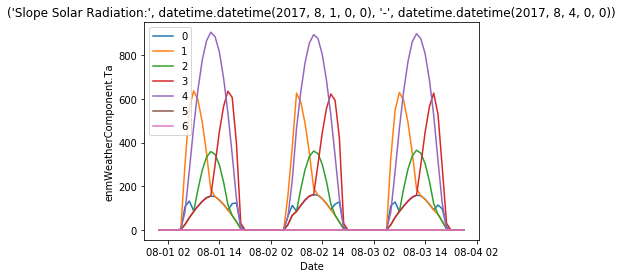

In [9]:
dtmStDate = datetime.datetime(2017, 8, 1)
dtmEnDate = datetime.datetime(2017, 8, 4)

Ndays = (dtmEnDate - dtmStDate).days
slope_Iw = [[0 for i in range(Ndays * 24)] for j in range(exsrf_mng.N())]
#slope_Iw = [[0 for i in range(exsrf_mng.N())] for j in range(Ndays * 24)]
xaxis = []
title = 'Slope Solar Radiation:', dtmStDate, '-', dtmEnDate
d = 0
# X軸の値を用意
for i in range((dtmEnDate - dtmStDate).days):
    for t in range(24):
        dtmDate = dtmStDate + datetime.timedelta(days = i) + datetime.timedelta(hours = t)
        xaxis.append(dtmDate)
        #print(dtmplot)
        sp = weatherdata.Solpos(dtmDate)
        Idn = weatherdata.WeaData(enmWeatherComponent.Idn, dtmDate)
        Isky = weatherdata.WeaData(enmWeatherComponent.Isky, dtmDate)
        exsrf_mng.CalcSlopSol(sp, Idn, Isky)
        for slope in range(exsrf_mng.N()):
            slope_Iw[slope][d] = exsrf_mng.ExsrfobjByIndex(slope).Iw()
        d += 1

#print(slope_Iw)
# 単位貫流応答のグラフ描画
for slope in range(exsrf_mng.N()):
    plt.plot( xaxis, slope_Iw[slope], label = slope)
#plt.plot(xaxis, slope_Iw)
plt.title( title )
plt.xlabel('Date')
plt.ylabel(enmWeatherComponent.Ta)
plt.legend()
#plt.legend()
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03261784990525286, 0.06222596104800821, 0.07849198361624497, 0.07529303538622976, 0.0537207051632544, 0.015041143212628097, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


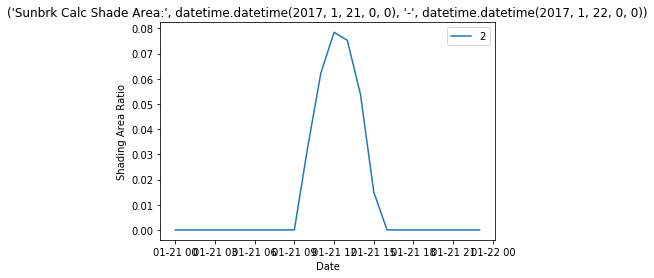

In [10]:
sunbrk = sunbrk_mng.Sunbrk('バルコニー')

dtmStDate = datetime.datetime(2017, 1, 21)
dtmEnDate = datetime.datetime(2017, 1, 22)

Ndays = (dtmEnDate - dtmStDate).days
Fsdw = [[0 for i in range(Ndays * 24)] for j in range(exsrf_mng.N())]
xaxis = []
title = 'Sunbrk Calc Shade Area:', dtmStDate, '-', dtmEnDate
d = 0
for i in range((dtmEnDate - dtmStDate).days):
    for t in range(24):
        dtmDate = dtmStDate + datetime.timedelta(days = i) + datetime.timedelta(hours = t)
        #print(dtmDate)
        # X軸の値を用意
        xaxis.append(dtmDate)
        #print(dtmplot)
        #太陽位置を計算
        sp = weatherdata.Solpos(dtmDate)
        exsrf_mng.CalcSlopSol(sp, Idn, Isky)
        for slope in range(exsrf_mng.N()):
            sunbrk.Exsrf(exsrf_mng.ExsrfobjByIndex(slope))
            Fsdw[slope][d] = sunbrk.FSDW(sp)
        d += 1

#print(slope_Iw)
# 単位貫流応答のグラフ描画
for slope in range(exsrf_mng.N()):
    if slope == 2:
        print(Fsdw[slope])
        plt.plot( xaxis, Fsdw[slope], label = slope)
#plt.plot(xaxis, slope_Iw)
plt.title( title )
plt.xlabel('Date')
plt.ylabel('Shading Area Ratio')
plt.legend()
#plt.legend()
plt.show()

In [11]:
#print(Spaces)

In [12]:
main.calcHload()

計算開始： 1988-12-13 00:00:00
計算終了： 1989-01-10 00:00:00
１日の計算ステップ数： 96
1988-12-13 00:00:00
Idi= 0.0 Iski= 0.0
1988-12-13 00:15:00
Idi= 0.0 Iski= 0.0
1988-12-13 00:30:00
Idi= 0.0 Iski= 0.0
1988-12-13 00:45:00
Idi= 0.0 Iski= 0.0
1988-12-13 01:00:00
Idi= 0.0 Iski= 0.0
1988-12-13 01:15:00
Idi= 0.0 Iski= 0.0
1988-12-13 01:30:00
Idi= 0.0 Iski= 0.0
1988-12-13 01:45:00
Idi= 0.0 Iski= 0.0
1988-12-13 02:00:00
Idi= 0.0 Iski= 0.0
1988-12-13 02:15:00
Idi= 0.0 Iski= 0.0
1988-12-13 02:30:00
Idi= 0.0 Iski= 0.0
1988-12-13 02:45:00
Idi= 0.0 Iski= 0.0
1988-12-13 03:00:00
Idi= 0.0 Iski= 0.0
1988-12-13 03:15:00
Idi= 0.0 Iski= 0.0
1988-12-13 03:30:00
Idi= 0.0 Iski= 0.0
1988-12-13 03:45:00
Idi= 0.0 Iski= 0.0
1988-12-13 04:00:00
Idi= 0.0 Iski= 0.0
1988-12-13 04:15:00
Idi= 0.0 Iski= 0.0
1988-12-13 04:30:00
Idi= 0.0 Iski= 0.0
1988-12-13 04:45:00
Idi= 0.0 Iski= 0.0
1988-12-13 05:00:00
Idi= 0.0 Iski= 0.0
1988-12-13 05:15:00
Idi= 0.0 Iski= 0.0
1988-12-13 05:30:00
Idi= 0.0 Iski= 0.0
1988-12-13 05:45:00
Idi= 0.0 Iski= 0

Idi= 0.0 Iski= 33.68055555555555
1988-12-17 15:00:00
Idi= 0.0 Iski= 30.55555555555555
1988-12-17 15:15:00
Idi= 0.0 Iski= 26.041666666666664
1988-12-17 15:30:00
Idi= 0.0 Iski= 21.527777777777775
1988-12-17 15:45:00
Idi= 0.0 Iski= 17.013888888888886
1988-12-17 16:00:00
Idi= 0.0 Iski= 12.5
1988-12-17 16:15:00
Idi= 0.0 Iski= 9.722222222222223
1988-12-17 16:30:00
Idi= 0.0 Iski= 6.944444444444445
1988-12-17 16:45:00
Idi= 0.0 Iski= 4.166666666666668
1988-12-17 17:00:00
Idi= 0.0 Iski= 1.38888888888889
1988-12-17 17:15:00
Idi= 0.0 Iski= 1.0416666666666674
1988-12-17 17:30:00
Idi= 0.0 Iski= 0.694444444444445
1988-12-17 17:45:00
Idi= 0.0 Iski= 0.3472222222222225
1988-12-17 18:00:00
Idi= 0.0 Iski= 0.0
1988-12-17 18:15:00
Idi= 0.0 Iski= 0.0
1988-12-17 18:30:00
Idi= 0.0 Iski= 0.0
1988-12-17 18:45:00
Idi= 0.0 Iski= 0.0
1988-12-17 19:00:00
Idi= 0.0 Iski= 0.0
1988-12-17 19:15:00
Idi= 0.0 Iski= 0.0
1988-12-17 19:30:00
Idi= 0.0 Iski= 0.0
1988-12-17 19:45:00
Idi= 0.0 Iski= 0.0
1988-12-17 20:00:00
Idi= 0.0

Idi= 0.0 Iski= 0.3472222222222225
1988-12-20 18:00:00
Idi= 0.0 Iski= 0.0
1988-12-20 18:15:00
Idi= 0.0 Iski= 0.0
1988-12-20 18:30:00
Idi= 0.0 Iski= 0.0
1988-12-20 18:45:00
Idi= 0.0 Iski= 0.0
1988-12-20 19:00:00
Idi= 0.0 Iski= 0.0
1988-12-20 19:15:00
Idi= 0.0 Iski= 0.0
1988-12-20 19:30:00
Idi= 0.0 Iski= 0.0
1988-12-20 19:45:00
Idi= 0.0 Iski= 0.0
1988-12-20 20:00:00
Idi= 0.0 Iski= 0.0
1988-12-20 20:15:00
Idi= 0.0 Iski= 0.0
1988-12-20 20:30:00
Idi= 0.0 Iski= 0.0
1988-12-20 20:45:00
Idi= 0.0 Iski= 0.0
1988-12-20 21:00:00
Idi= 0.0 Iski= 0.0
1988-12-20 21:15:00
Idi= 0.0 Iski= 0.0
1988-12-20 21:30:00
Idi= 0.0 Iski= 0.0
1988-12-20 21:45:00
Idi= 0.0 Iski= 0.0
1988-12-20 22:00:00
Idi= 0.0 Iski= 0.0
1988-12-20 22:15:00
Idi= 0.0 Iski= 0.0
1988-12-20 22:30:00
Idi= 0.0 Iski= 0.0
1988-12-20 22:45:00
Idi= 0.0 Iski= 0.0
1988-12-20 23:00:00
Idi= 0.0 Iski= 0.0
1988-12-20 23:15:00
Idi= 0.0 Iski= 0.0
1988-12-20 23:30:00
Idi= 0.0 Iski= 0.0
1988-12-20 23:45:00
Idi= 0.0 Iski= 0.0
1988-12-21 00:00:00
Idi= 0.0 I

Idi= 0.0 Iski= 0.0
1988-12-24 22:00:00
Idi= 0.0 Iski= 0.0
1988-12-24 22:15:00
Idi= 0.0 Iski= 0.0
1988-12-24 22:30:00
Idi= 0.0 Iski= 0.0
1988-12-24 22:45:00
Idi= 0.0 Iski= 0.0
1988-12-24 23:00:00
Idi= 0.0 Iski= 0.0
1988-12-24 23:15:00
Idi= 0.0 Iski= 0.0
1988-12-24 23:30:00
Idi= 0.0 Iski= 0.0
1988-12-24 23:45:00
Idi= 0.0 Iski= 0.0
1988-12-25 00:00:00
Idi= 0.0 Iski= 0.0
1988-12-25 00:15:00
Idi= 0.0 Iski= 0.0
1988-12-25 00:30:00
Idi= 0.0 Iski= 0.0
1988-12-25 00:45:00
Idi= 0.0 Iski= 0.0
1988-12-25 01:00:00
Idi= 0.0 Iski= 0.0
1988-12-25 01:15:00
Idi= 0.0 Iski= 0.0
1988-12-25 01:30:00
Idi= 0.0 Iski= 0.0
1988-12-25 01:45:00
Idi= 0.0 Iski= 0.0
1988-12-25 02:00:00
Idi= 0.0 Iski= 0.0
1988-12-25 02:15:00
Idi= 0.0 Iski= 0.0
1988-12-25 02:30:00
Idi= 0.0 Iski= 0.0
1988-12-25 02:45:00
Idi= 0.0 Iski= 0.0
1988-12-25 03:00:00
Idi= 0.0 Iski= 0.0
1988-12-25 03:15:00
Idi= 0.0 Iski= 0.0
1988-12-25 03:30:00
Idi= 0.0 Iski= 0.0
1988-12-25 03:45:00
Idi= 0.0 Iski= 0.0
1988-12-25 04:00:00
Idi= 0.0 Iski= 0.0
1988-1

Idi= 0.0 Iski= 0.0
1988-12-29 02:00:00
Idi= 0.0 Iski= 0.0
1988-12-29 02:15:00
Idi= 0.0 Iski= 0.0
1988-12-29 02:30:00
Idi= 0.0 Iski= 0.0
1988-12-29 02:45:00
Idi= 0.0 Iski= 0.0
1988-12-29 03:00:00
Idi= 0.0 Iski= 0.0
1988-12-29 03:15:00
Idi= 0.0 Iski= 0.0
1988-12-29 03:30:00
Idi= 0.0 Iski= 0.0
1988-12-29 03:45:00
Idi= 0.0 Iski= 0.0
1988-12-29 04:00:00
Idi= 0.0 Iski= 0.0
1988-12-29 04:15:00
Idi= 0.0 Iski= 0.0
1988-12-29 04:30:00
Idi= 0.0 Iski= 0.0
1988-12-29 04:45:00
Idi= 0.0 Iski= 0.0
1988-12-29 05:00:00
Idi= 0.0 Iski= 0.0
1988-12-29 05:15:00
Idi= 0.0 Iski= 0.0
1988-12-29 05:30:00
Idi= 0.0 Iski= 0.0
1988-12-29 05:45:00
Idi= 0.0 Iski= 0.0
1988-12-29 06:00:00
Idi= 0.0 Iski= 0.0
1988-12-29 06:15:00
Idi= 0.0 Iski= 0.3472222222222225
1988-12-29 06:30:00
Idi= 0.0 Iski= 0.694444444444445
1988-12-29 06:45:00
Idi= 0.0 Iski= 1.0416666666666674
1988-12-29 07:00:00
Idi= 0.0 Iski= 1.38888888888889
1988-12-29 07:15:00
Idi= 0.0 Iski= 6.250000000000005
1988-12-29 07:30:00
Idi= 151.35357664229815 Iski= 11

IndexError: list index out of range